# Scube tutorial: 3D expression modeling with gaussian process regression

September 2022

Dataset: 33 MERFISH slices of mouse brain ([here](#)).

In [2]:
from SPACEL.setting import set_environ_seed, auto_cuda_device
set_environ_seed()
from SPACEL import Scube
import scanpy as sc
import numpy as np
import pandas as pd
np.random.seed(42)

Setting environment seed: 42


## Load data

The input data type of 3D expression model is normalized expression and 3D coordinates of each spot/cell.

In [5]:
st_ad = sc.read_h5ad('../data/starmap_3d_mouse_brain/starmap_3d.h5ad')
sc.pp.normalize_total(st_ad,target_sum=1e4)
sc.pp.log1p(st_ad)

# Normalized expression data (rows as spots/cells, columns as genes)
norm_expr = st_ad.to_df()

# 3D location (rows as spots/cells, columns as x,y,z axis coordinate)
loc = st_ad.obsm['spatial'].copy()

## Generate 3D surface

In this step, we create a triangle mesh from 3D location coordinates of spots/cells by using alpha shape methods. The parameter `alpha` affect the number of triangle in the mesh. 

In [6]:
mesh = Scube.utils_3d.create_mesh(loc.values,alpha=80,show=False)

alpha=80.000
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh


To obtain smoothed mesh, we can used Taubin filter and mesh subdivision for the mesh.

In [7]:
mesh = Scube.utils_3d.smooth_mesh(mesh,taubin_iter=10,subdivide_iter=3,show=False)

filter with Taubin with 10 iterations
After subdivision it has 345092 vertices and 690176 triangles


Sampling 500000 location coordinates from inside the mesh and getting the vertices of the mesh surface.

In [8]:
loc_sampled,loc_surface = Scube.utils_3d.sample_in_mesh(mesh,loc.values)

## Gaussian process regression

For better performance of GPR model, we recommend to resize the location coordinates value to about 0 to 10.

In [9]:
loc = loc/1000
loc_sampled = loc_sampled/1000

Then, we construct the GPR model and training it until convergence. If GPU devices avaliable, set `use_gpu` to `True`

In [10]:
gpr_model = Scube.GPRmodel(norm_expr,loc.values,loc_sampled,used_genes=norm_expr.columns,use_gpu=False)

In [11]:
gpr_model.train(lr=.02,training_iter=50,save_model=True,cal_bf=True,optim_l=True,optimize_method='Adam')

Modeling Slc17a7
Optimize lenthscale...


/opt/miniconda3/envs/SPACEL/lib/python3.8/site-packages/SPACEL-1.0a0-py3.8.egg/SPACEL/Scube/gpr.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  constant = torch.tensor(self.train_y.mean())
/opt/miniconda3/envs/SPACEL/lib/python3.8/site-packages/gpytorch/functions/_pivoted_cholesky.py:118: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  [L, torch.triangular_solve(Krows[..., m:, :].transpose(-1, -2), L, upper=Fals

Initialize lenthscale alpha as 1.000
Best model loss: 1.1666253805160522
Best model loss: 1.548324704170227
0.3816993236541748
Modeling Mgp
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 0.6543543338775635
Best model loss: 0.991144061088562
0.33678972721099854
Modeling Gad1
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 1.7622023820877075
Best model loss: 1.8489148616790771
0.08671247959136963
Modeling Nov
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 1.706119179725647
Best model loss: 1.7335630655288696
0.027443885803222656
Modeling Rasgrf2
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 0.5395879149436951
Best model loss: 0.8652480244636536
0.3256601095199585
Modeling Rorb
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 0.9758266806602478
Best model loss: 1.1724785566329956
0.1966518759727478
Modeling Cux2
Optimize lenthscale...
Initiali

/opt/miniconda3/envs/SPACEL/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Initialize lenthscale alpha as 1.000
Best model loss: 1.4984480142593384
Best model loss: 1.8526679277420044
0.354219913482666
Modeling Sema3e
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 1.415098786354065
Best model loss: 1.5002400875091553
0.08514130115509033
Modeling Npy
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 1.6847648620605469
Best model loss: 2.013796091079712
0.32903122901916504
Modeling Sst
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 2.00138521194458
Best model loss: 2.1906580924987793
0.18927288055419922
Modeling Pvalb
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 2.120755910873413
Best model loss: 2.386117696762085
0.2653617858886719
Modeling Vip
Optimize lenthscale...
Initialize lenthscale alpha as 1.000
Best model loss: 2.1072800159454346
Best model loss: 2.3525805473327637
0.2453005313873291
Modeling Calb2
Optimize lenthscale...
Initialize le

By calculating bayes factor, we can statistical identification the spatially varying genes in 3D expression model. For a gene, larger Bayes factor values indicate more spatial variation.

In [12]:
gpr_model.log_bf.sort_values(by='log_bf',ascending=False)

,log_bf
Cux2,0.649313
Mbp,0.432827
Plcxd2,0.414846
Slc17a7,0.381699
Egr2,0.361869
Pcp4,0.35422
Calb2,0.34775
Mgp,0.33679
Npy,0.329031
Egr1,0.328469


## Visualization

Visualization of the GRP model result for any genes.

/opt/miniconda3/envs/SPACEL/lib/python3.8/site-packages/SPACEL-1.0a0-py3.8.egg/SPACEL/Scube/gpr.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observed_pred_batch = self.model.likelihood(self.model(torch.tensor(data_batch)))


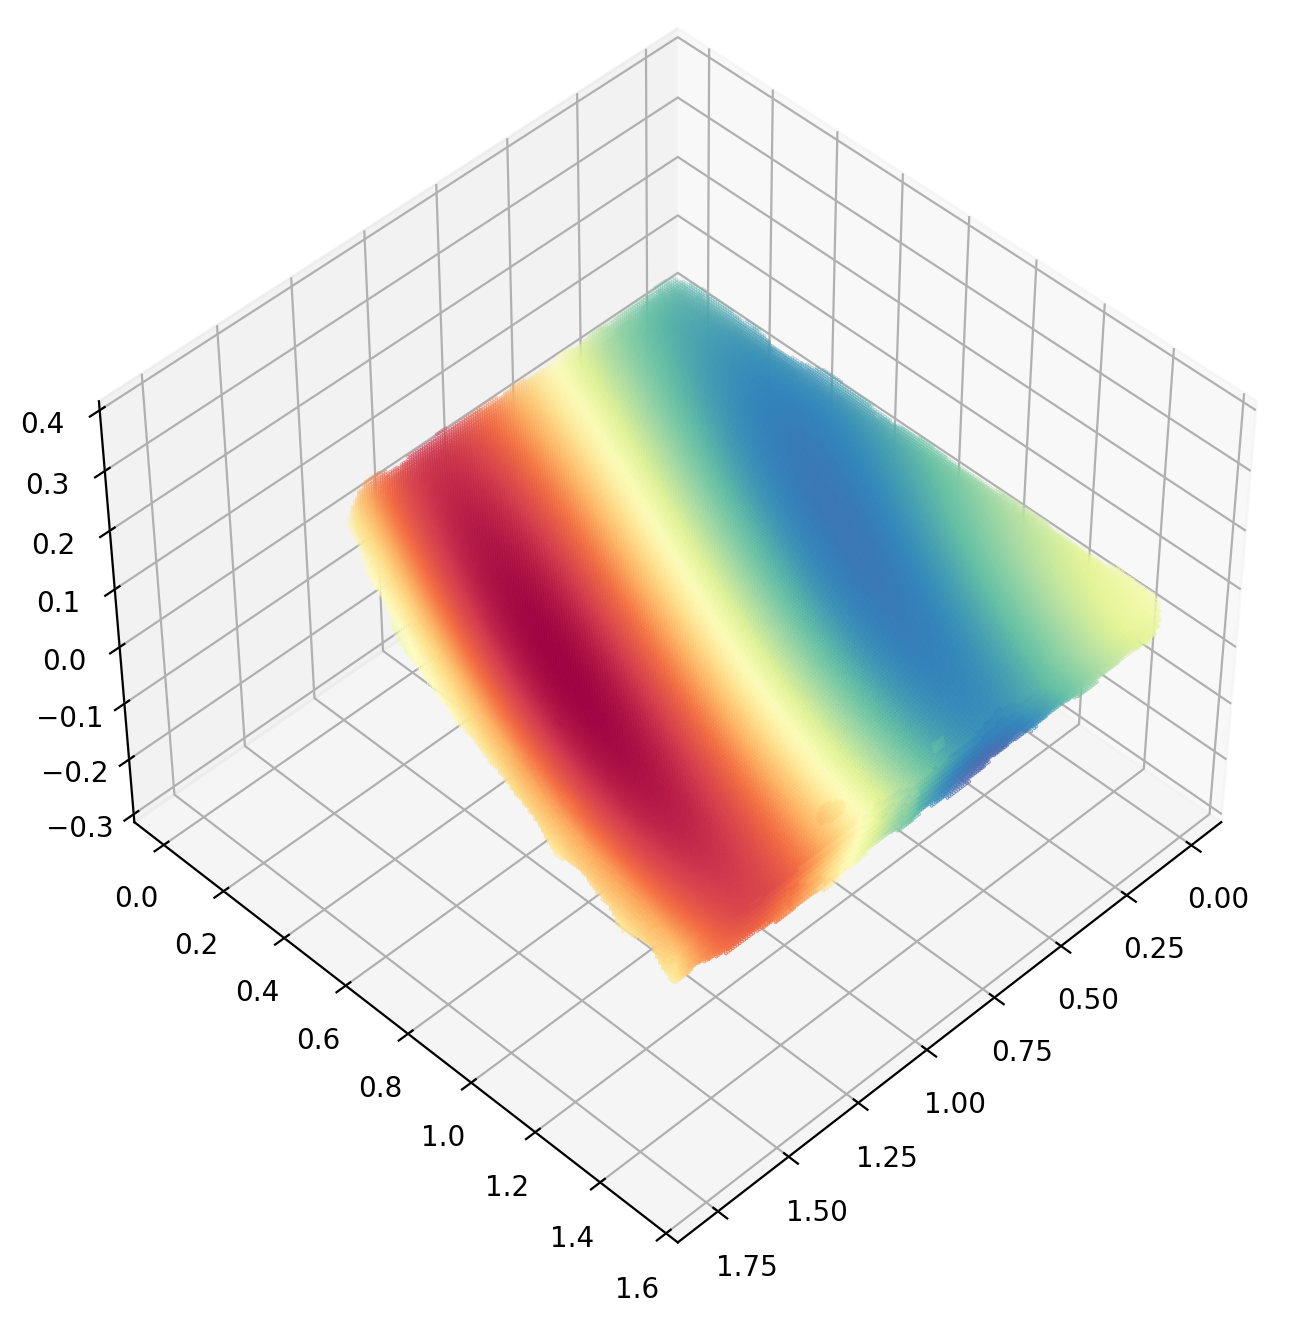

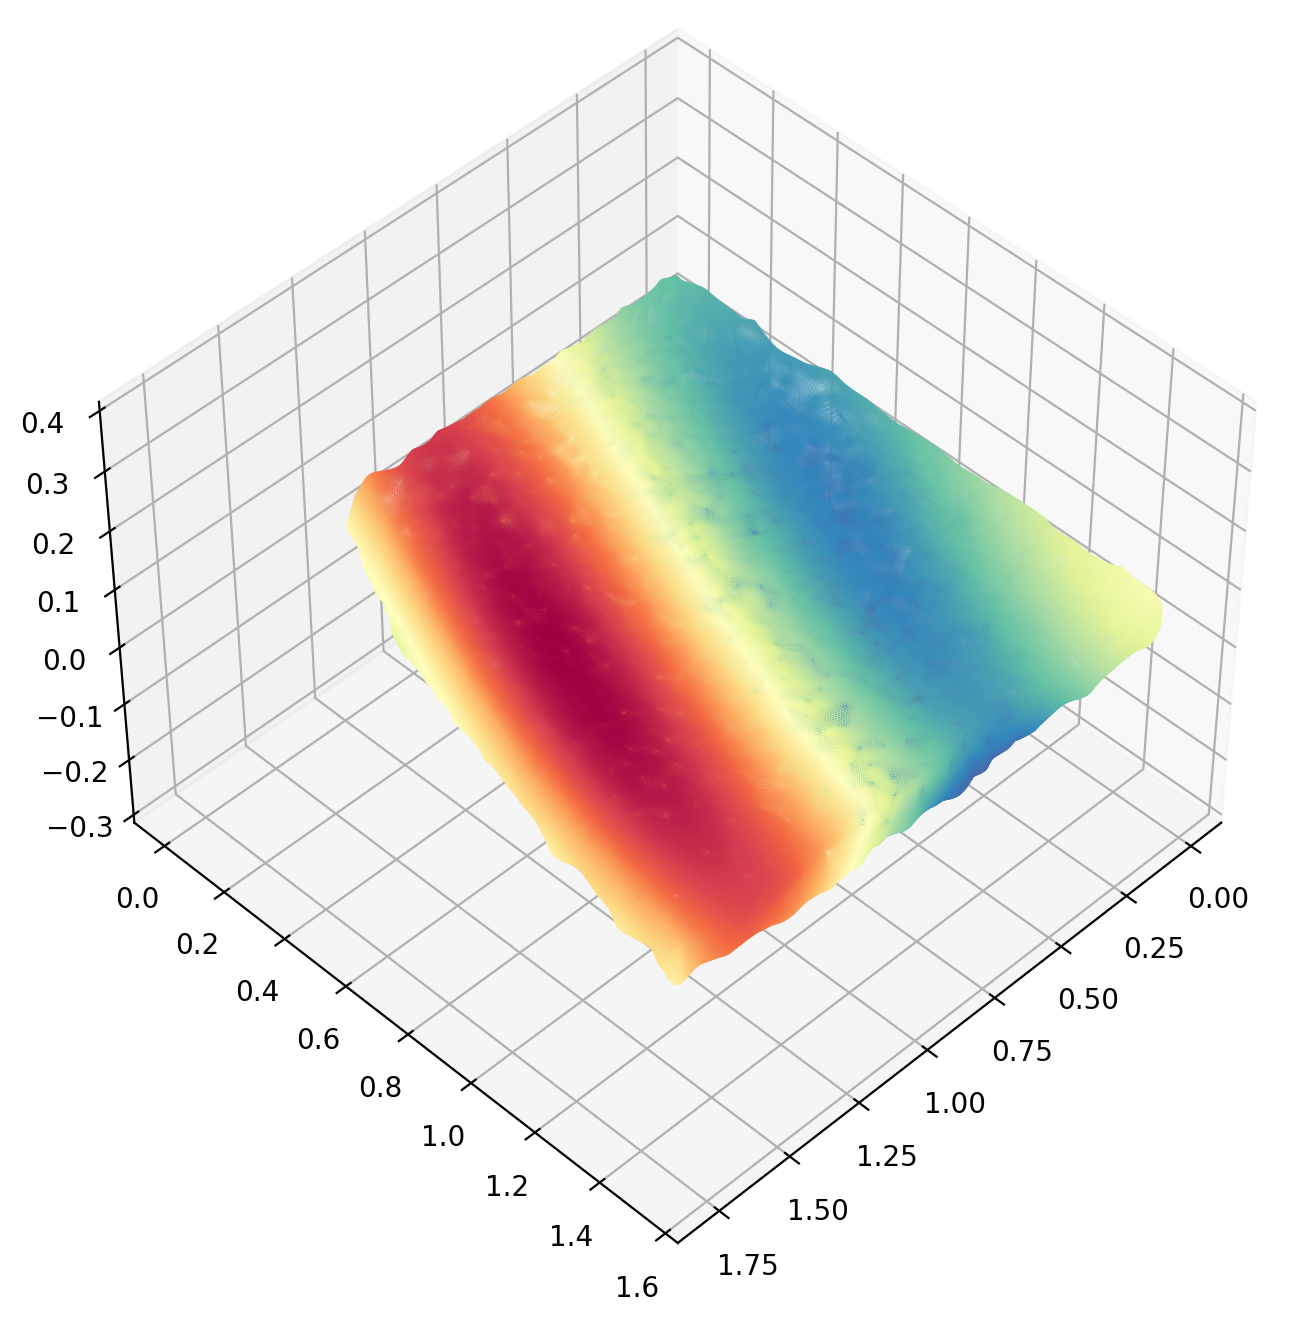

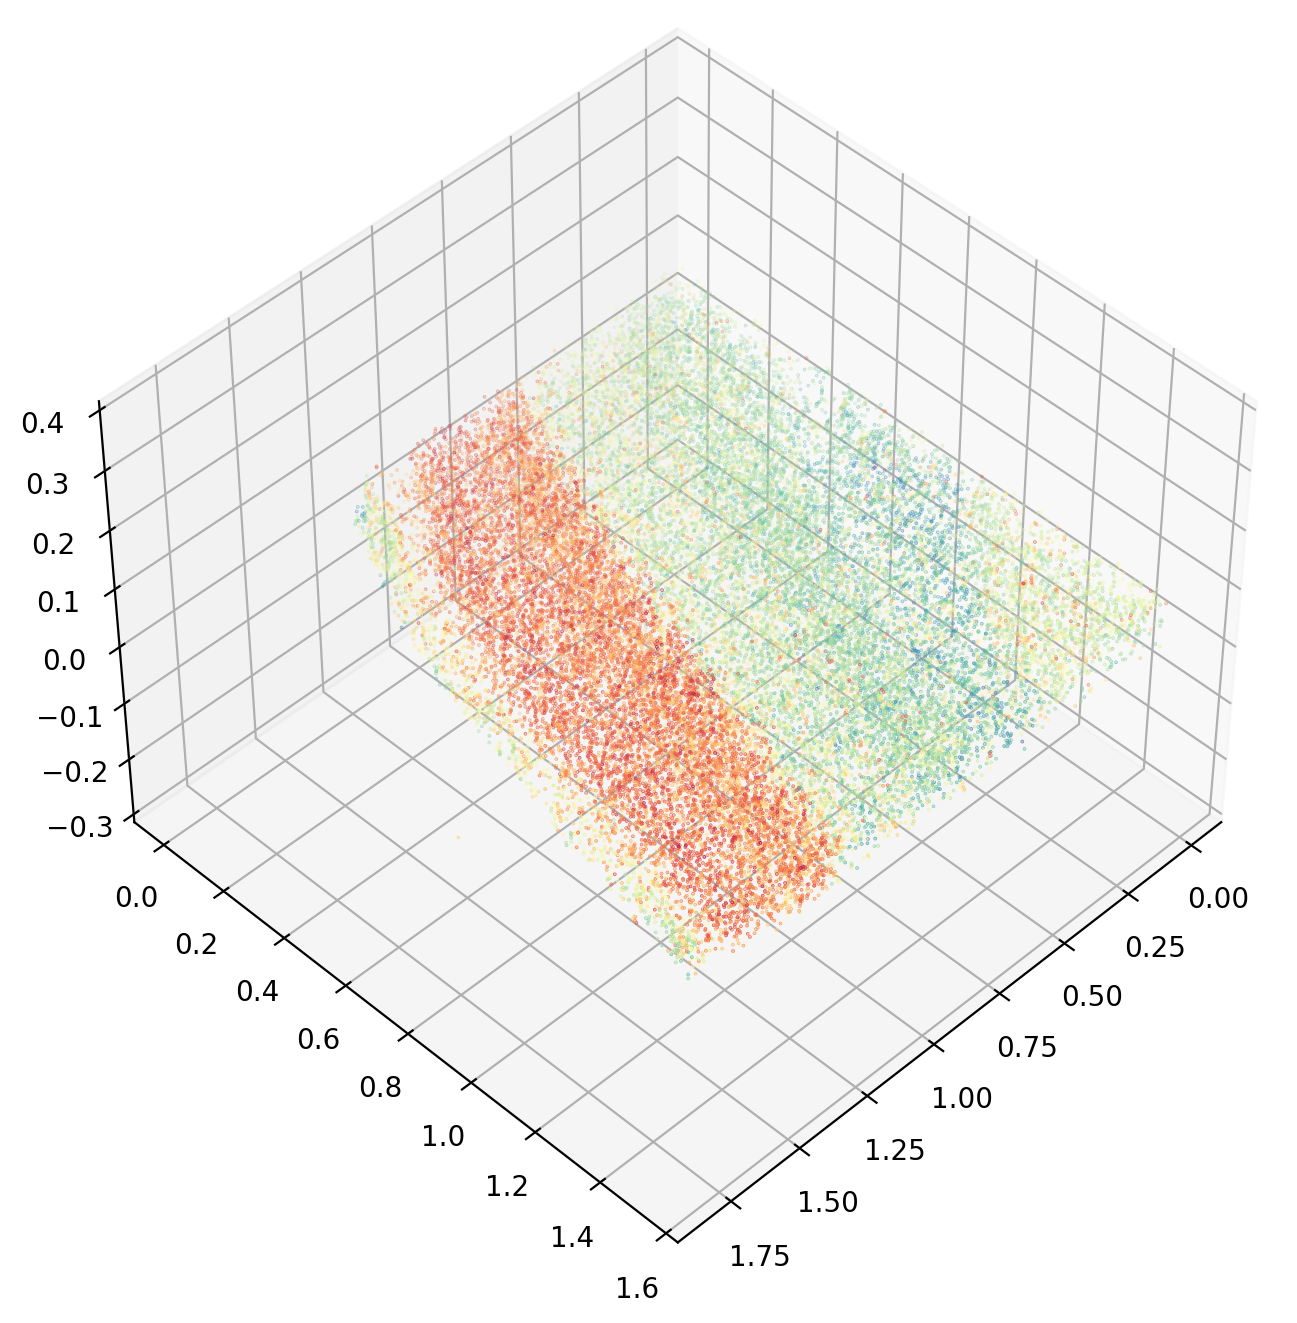

In [13]:
g = 'Cux2'

# Expression of sampled location from the 3D mesh
sampled_expr = gpr_model.plot_gpr_expr(g,s=.1,training_iter=50,lr=.02,save=False,show=True,elev=45,azim=45,cmap='Spectral_r',zlim=(-0.3,0.4))

# Expression of surface location from the 3D mesh
surface_expr = gpr_model.plot_gpr_expr(g,data=loc_surface/1000,s=.1,training_iter=50,lr=.02,save=False,show=True,elev=45,azim=45,cmap='Spectral_r',zlim=(-0.3,0.4))

# Expression of measurement location from the observation
Scube.plot_3d(loc=loc.values,val=norm_expr[g],s=.1,show=True,elev=45,azim=45,zlim=(-0.3,0.4))

This step colored mesh surface with GPR expression. It can be used for visualization of the GRP model result with `Open3D` library. 

In [14]:
Scube.utils_3d.get_surface_colors(mesh,surface_expr)

Save the camera view parameters in a json file and then load it at the next visualization.

In [15]:
Scube.utils_3d.save_view_parameters(mesh, 'view_parameters.json')

In [16]:
g = 'Mbp'
# Expression of surface location from the 3D mesh
surface_expr = gpr_model.plot_gpr_expr(g,data=loc_surface/1000,s=.1,training_iter=50,lr=.02,save=False,show=False,elev=45,azim=45,cmap='Spectral_r',zlim=(-0.3,0.4))
Scube.utils_3d.get_surface_colors(mesh,surface_expr)
Scube.utils_3d.load_view_parameters(mesh, 'view_parameters.json')